|Trading Indictators|
|-|

In [33]:
#libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#libs -> data collection
import requests
from datetime import datetime
import ta

#keys
from config import IEX_KEY


In [14]:
# Replace 'your_api_key' with your actual IEX Cloud API key
api_key = IEX_KEY
symbol = 'TSLA' # Tesla

# Define the base URL and endpoint for the IEX Cloud API
base_url = 'https://cloud.iexapis.com/stable'
endpoint = f'/stock/{symbol}/quote'

# Set up the request URL with your API key
url = f'{base_url}{endpoint}?token={api_key}'

# Send an HTTP GET request to the IEX Cloud API and retrieve the response
response = requests.get(url)
data = response.json()

# Print the stock data for TSLA
print(f"Symbol: {data['symbol']}")
print(f"Company Name: {data['companyName']}")
print(f"Latest Price: ${data['latestPrice']}")
print(f"Previous Close: ${data['previousClose']}")
print(f"Change: ${data['change']} ({data['changePercent']}%)")

Symbol: TSLA
Company Name: Tesla Inc
Latest Price: $180.59
Previous Close: $184.31
Change: $-3.72 (-0.02018%)


|Part deux|
|-|

In [18]:
api_key = IEX_KEY
symbol = 'TSLA'

# Define the base URL and endpoint for the IEX Cloud API
base_url = 'https://cloud.iexapis.com/stable' # paid API (tokens)
endpoint = f'/stock/{symbol}/chart/1y' # 1 year chart

url = f'{base_url}{endpoint}?token={api_key}' # pass my key

# HTTP GET request to the IEX Cloud API and retrieve the response
response = requests.get(url)
data = response.json()


In [19]:
# empty df to CONCAT to -> there is a change here with python3, use concat instead of append. kinda weird but I guess bp. 
columns = ['date', 'symbol', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(columns=columns)

# populate the DataFrame with the historical data
for daily_data in data:
    date = daily_data['date']
    open_price = daily_data['open']
    high = daily_data['high']
    low = daily_data['low']
    close = daily_data['close']
    adj_close = daily_data['close']  # the IEX API doesn't provide adjusted close; using close price as a proxy
    volume = daily_data['volume']
    
    # CONCAT (append)the data to the DataFrame
    row_data = pd.DataFrame({
        'date': [date],
        'symbol': [symbol],
        'open': [open_price],
        'high': [high],
        'low': [low],
        'close': [close],
        'adj_close': [adj_close],
        'volume': [volume]
    })

    df = pd.concat([df, row_data], ignore_index=True)

# convert the 'date' column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'])

# display the DataFrame
df 

,date,symbol,open,high,low,close,adj_close,volume
0,2022-04-20,TSLA,343.333,344.6670,325.0830,325.733,325.733,70711326.0
1,2022-04-21,TSLA,358.243,364.0730,332.1380,336.260,336.260,105416337.0
2,2022-04-22,TSLA,338.303,344.9500,331.3330,335.017,335.017,69696558.0
3,2022-04-25,TSLA,326.323,336.2070,325.1000,332.673,332.673,68341335.0
4,2022-04-26,TSLA,331.810,333.3330,291.6670,292.140,292.140,136133667.0
...,...,...,...,...,...,...,...,...
245,2023-04-12,TSLA,190.740,191.5846,180.3100,180.540,180.540,150256278.0
246,2023-04-13,TSLA,182.955,186.5000,180.9400,185.900,185.900,112932985.0
247,2023-04-14,TSLA,183.950,186.2800,182.0100,185.000,185.000,96438664.0
248,2023-04-17,TSLA,186.320,189.6900,182.6900,187.040,187.040,116662189.0


In [20]:
# set date as the index
df = df.set_index(pd.DatetimeIndex(df['date'].values))

# display tail
df.tail(10)

,date,symbol,open,high,low,close,adj_close,volume
2023-04-04,2023-04-04,TSLA,197.320,198.7446,190.3200,192.58,192.58,126463845.0
2023-04-05,2023-04-05,TSLA,190.515,190.6800,183.7600,185.52,185.52,133882493.0
2023-04-06,2023-04-06,TSLA,183.080,186.3900,179.7400,185.06,185.06,123857932.0
2023-04-10,2023-04-10,TSLA,179.940,185.1000,176.1100,184.51,184.51,142154637.0
2023-04-11,2023-04-11,TSLA,186.690,189.1900,185.6475,186.79,186.79,115770892.0
2023-04-12,2023-04-12,TSLA,190.740,191.5846,180.3100,180.54,180.54,150256278.0
2023-04-13,2023-04-13,TSLA,182.955,186.5000,180.9400,185.90,185.90,112932985.0
2023-04-14,2023-04-14,TSLA,183.950,186.2800,182.0100,185.00,185.00,96438664.0
2023-04-17,2023-04-17,TSLA,186.320,189.6900,182.6900,187.04,187.04,116662189.0
2023-04-18,2023-04-18,TSLA,187.150,187.6900,183.5775,184.31,184.31,92067016.0


In [21]:
# create SMA and EMA functions

# Simple Moving Average (SMA)
def SMA(data,period=30, column='close'):
    return data[column].rolling(window=period).mean()

# Exponential Moving Average (EMA)
def EMA(data,period=20, column='close'):
    return data[column].ewm(span=period, adjust = False).mean()

In [22]:
# calculate the MACD (Moving Average Convergence/Divergence)
def MACD(data, period_long=26, period_short=12, period_signal=9, column='close'):
    # calculate short term exponential moving average
    shortEMA = EMA(data, period_short, column=column)
    # calc long term exp ma
    longEMA = EMA(data, period_long, column=column)
    # calc macd
    data['MACD'] = (shortEMA - longEMA)
    # calc the signal line
    data['signal_line'] = EMA(data, period_signal, column='MACD')

    return data

In [23]:
# RSI function
def RSI(data, period = 14, column='close'):
    delta = data[column].diff(1)
    delta = delta[1:] # removes header row from calc
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up 
    data['down'] = down
    avg_gain = SMA(data, period, column='up')
    avg_loss = abs(SMA(data, period, column='down'))
    RS = avg_gain / avg_loss
    RSI = 100.0 - (100.0/(1.0 + RS))

    data['RSI'] = RSI

    return data

In [24]:
# add to the data set
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)


In [25]:
# show data
df

,date,symbol,open,high,low,close,adj_close,volume,MACD,signal_line,up,down,RSI,SMA,EMA
2022-04-20,2022-04-20,TSLA,343.333,344.6670,325.0830,325.733,325.733,70711326.0,0.000000,0.000000,NaN,NaN,NaN,NaN,325.733000
2022-04-21,2022-04-21,TSLA,358.243,364.0730,332.1380,336.260,336.260,105416337.0,0.839761,0.167952,10.527,0.000,NaN,NaN,326.735571
2022-04-22,2022-04-22,TSLA,338.303,344.9500,331.3330,335.017,335.017,69696558.0,1.388966,0.412155,0.000,-1.243,NaN,NaN,327.524279
2022-04-25,2022-04-25,TSLA,326.323,336.2070,325.1000,332.673,332.673,68341335.0,1.616441,0.653012,0.000,-2.344,NaN,NaN,328.014633
2022-04-26,2022-04-26,TSLA,331.810,333.3330,291.6670,292.140,292.140,136133667.0,-1.457161,0.230978,0.000,-40.533,NaN,NaN,324.598002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12,2023-04-12,TSLA,190.740,191.5846,180.3100,180.540,180.540,150256278.0,-0.420451,1.005571,0.000,-6.250,40.635481,188.193000,188.743711
2023-04-13,2023-04-13,TSLA,182.955,186.5000,180.9400,185.900,185.900,112932985.0,-0.564391,0.691579,5.360,0.000,44.814572,187.630667,188.472882
2023-04-14,2023-04-14,TSLA,183.950,186.2800,182.0100,185.000,185.000,96438664.0,-0.742527,0.404758,0.000,-0.900,45.493920,187.434000,188.142131
2023-04-17,2023-04-17,TSLA,186.320,189.6900,182.6900,187.040,187.040,116662189.0,-0.710896,0.181627,2.040,0.000,46.068897,187.075667,188.037166


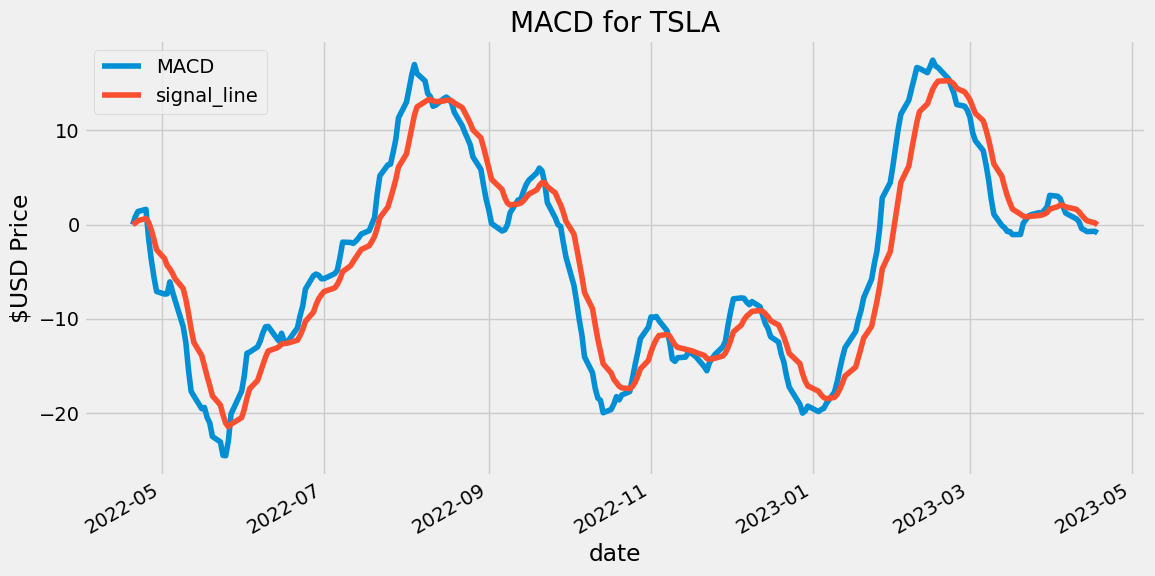

In [28]:
# plot the chart
# create a list of columns to keep
column_list = ['MACD', 'signal_line']
df[column_list].plot(figsize=(12.2,6.4))
plt.title(f'MACD for {symbol}')
plt.ylabel('$USD Price')
plt.xlabel('date')
plt.show()

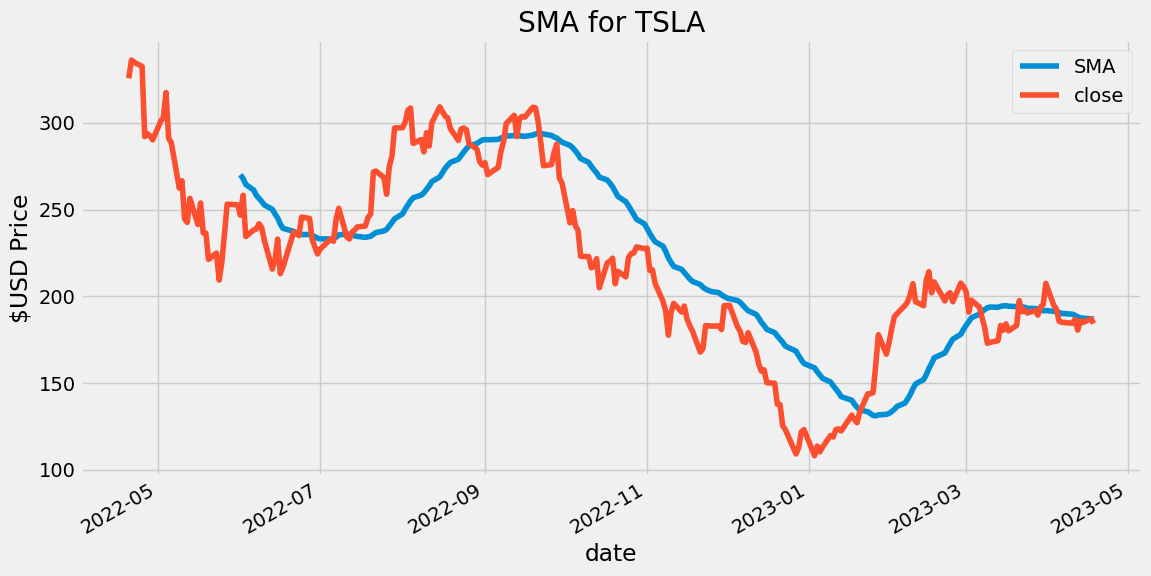

In [29]:
# plot the chart
# create a list of columns to keep
column_list = ['SMA', 'close']
df[column_list].plot(figsize=(12.2,6.4))
plt.title(f'SMA for {symbol}')
plt.ylabel('$USD Price')
plt.xlabel('date')
plt.show()

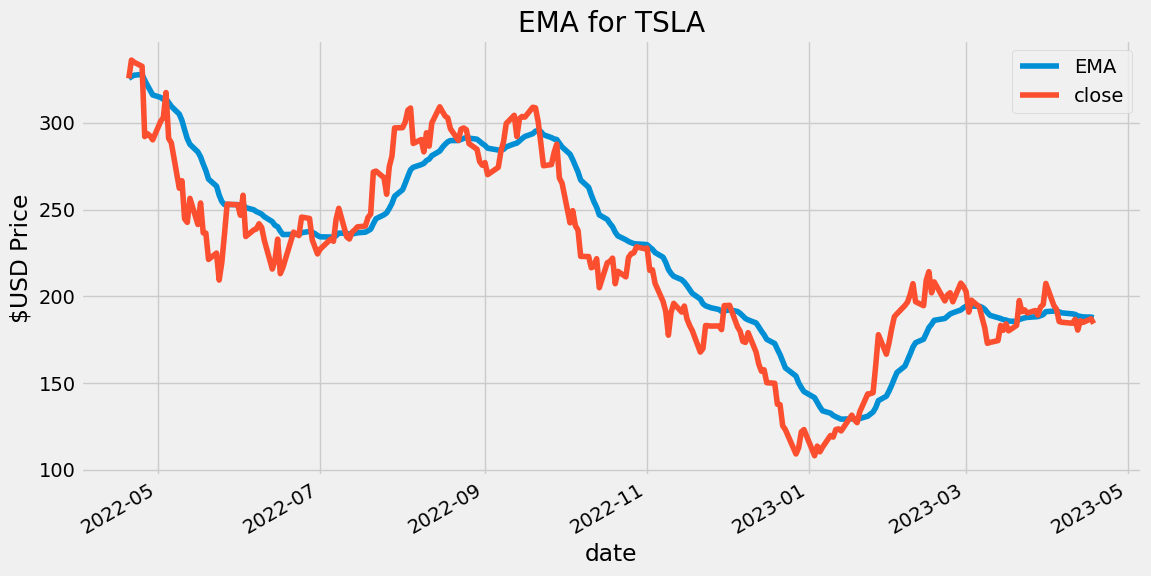

In [30]:
# PLOT
# create a list of columns to keep
column_list = ['EMA', 'close']
df[column_list].plot(figsize=(12.2,6.4))
plt.title(f'EMA for {symbol}')
plt.ylabel('$USD Price')
plt.xlabel('date')
plt.show()

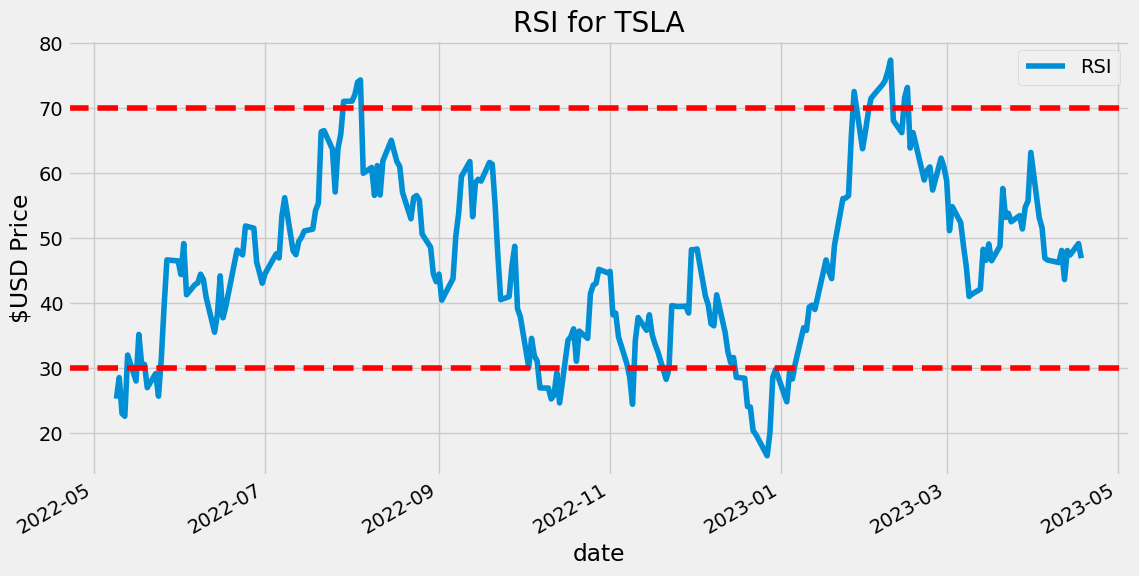

In [35]:
# PLOT
# create a list of columns to keep
column_list = ['RSI']
df[column_list].plot(figsize=(12.2,6.4))
plt.title(f'RSI for {symbol}')
plt.ylabel('$USD Price')
plt.xlabel('date')
plt.axhline(30, color='red', linestyle='--')  # Add a horizontal line at 30 to indicate oversold
plt.axhline(70, color='red', linestyle='--')  # Add a horizontal line at 70 to indicate overbought
plt.show()

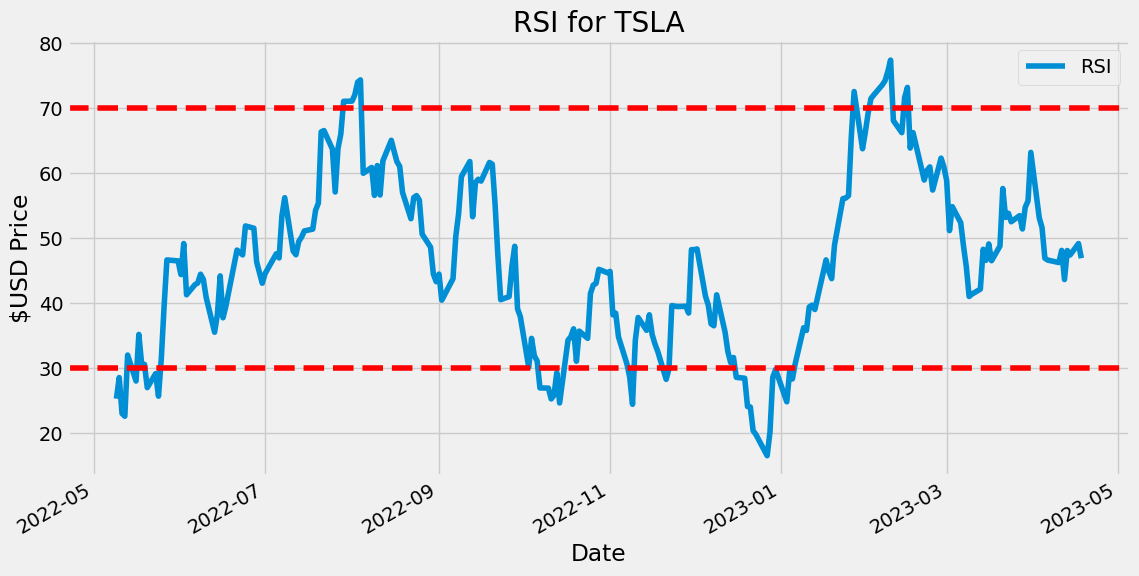

In [34]:
"""
Second method
-same or similar outcome
"""
# Calculate the RSI using the ta library
df['RSI'] = ta.momentum.RSIIndicator(df['close']).rsi()

# Plot the RSI
column_list = ['RSI']
df[column_list].plot(figsize=(12.2, 6.4))
plt.title(f'RSI for {symbol}')
plt.ylabel('$USD Price')
plt.xlabel('Date')
plt.axhline(30, color='red', linestyle='--')  # Add a horizontal line at 30 to indicate oversold
plt.axhline(70, color='red', linestyle='--')  # Add a horizontal line at 70 to indicate overbought
plt.show()

|END OF PROGRAM|
|-|
|Notes and other code below|

In [9]:
# Define the base URL and endpoint for the IEX Cloud API
base_url = 'https://cloud.iexapis.com/stable'
endpoint = f'/stock/{symbol}/chart/1y'  # Get historical prices for the last year

# Set up the request URL with your API key
url = f'{base_url}{endpoint}?token={api_key}'

# Send an HTTP GET request to the IEX Cloud API and retrieve the response
response = requests.get(url)
data = response.json()
print(data)

[{'close': 325.733, 'high': 344.667, 'low': 325.083, 'open': 343.333, 'priceDate': '2022-04-20', 'symbol': 'TSLA', 'volume': 70711326.00000007, 'id': 'HISTORICAL_PRICES', 'key': 'TSLA', 'subkey': '', 'date': '2022-04-20', 'updated': 1661544969000, 'changeOverTime': 0, 'marketChangeOverTime': 0, 'uOpen': 1030, 'uClose': 977.2, 'uHigh': 1034, 'uLow': 975.2501, 'uVolume': 23570442, 'fOpen': 343.333, 'fClose': 325.733, 'fHigh': 344.667, 'fLow': 325.083, 'fVolume': 70711326.00000007, 'label': 'Apr 20, 22', 'change': 0, 'changePercent': 0}, {'close': 336.26, 'high': 364.073, 'low': 332.138, 'open': 358.243, 'priceDate': '2022-04-21', 'symbol': 'TSLA', 'volume': 105416337.0000001, 'id': 'HISTORICAL_PRICES', 'key': 'TSLA', 'subkey': '', 'date': '2022-04-21', 'updated': 1661544972000, 'changeOverTime': 0.032317879981457166, 'marketChangeOverTime': 0.032317879981457166, 'uOpen': 1074.73, 'uClose': 1008.78, 'uHigh': 1092.22, 'uLow': 996.415, 'uVolume': 35138779, 'fOpen': 358.243, 'fClose': 336.26

In [12]:
# Print the historical prices for TSLA
print(f"Historical prices for {symbol} over the last year:")
for daily_data in data:
    date = datetime.strptime(daily_data['date'], '%Y-%m-%d').strftime('%b %d, %Y')
    close = daily_data['close']
    print(f"{date}: ${close}")

Historical prices for TSLA over the last year:
Apr 20, 2022: $325.733
Apr 21, 2022: $336.26
Apr 22, 2022: $335.017
Apr 25, 2022: $332.673
Apr 26, 2022: $292.14
Apr 27, 2022: $293.837
Apr 28, 2022: $292.503
Apr 29, 2022: $290.253
May 02, 2022: $300.98
May 03, 2022: $303.083
May 04, 2022: $317.54
May 05, 2022: $291.093
May 06, 2022: $288.55
May 09, 2022: $262.37
May 10, 2022: $266.68
May 11, 2022: $244.667
May 12, 2022: $242.667
May 13, 2022: $256.53
May 16, 2022: $241.457
May 17, 2022: $253.87
May 18, 2022: $236.603
May 19, 2022: $236.473
May 20, 2022: $221.3
May 23, 2022: $224.967
May 24, 2022: $209.387
May 25, 2022: $219.6
May 26, 2022: $235.91
May 27, 2022: $253.21
May 31, 2022: $252.753
Jun 01, 2022: $246.79
Jun 02, 2022: $258.333
Jun 03, 2022: $234.517
Jun 06, 2022: $238.28
Jun 07, 2022: $238.887
Jun 08, 2022: $241.867
Jun 09, 2022: $239.707
Jun 10, 2022: $232.23
Jun 13, 2022: $215.737
Jun 14, 2022: $220.89
Jun 15, 2022: $233
Jun 16, 2022: $213.1
Jun 17, 2022: $216.76
Jun 21, 2022: